# Isolating Bioelectrical Signal by Leak Subtraction

### *Personal Note*

*I selected this tutorial simply because I thought it was neat. From a general data science perspective it demonstates signal processing, parameter optimization, model fitting, and some biophysics. The data was part of a more extensive projected were I explored the application of stem cell derived cardiomyocytes in arrhythmia detection. I hope you find it interesting.*

## Introduction

Electrial signals play a critical role in the normal physiology of biological cells. Consequently, it is of interest to understand and develop models of cellular electrophysiology for biotechnical and theraputic reasons. The development of electrophysiolgical models and experimental techniques to measure bioelectrical activity has an incredibly rich history. I found the field interesting because it is an area of biology that can be studied from a from a bottom-up approach.

The technical setup I used to acquire the data used here is called a voltage patch clamp (VC). During a VC experiment an electrode is placed beneath the cellular membrane to control the voltage across the membrane. A time-series of voltages are then input across the cellular membrane and the total current is recorded as output.

This particular data is my out-of-sample data that I need to clean up to evaluate the model's predictive performance.

The time-series data is defined:

***Input***: Voltage in $millivolt\text{ }(mV) $<br>
***Output***: Current density in $picoampere * picofarad^{-1}\text{ }(pA/pF)$

Let's take a look at the data.

In [4]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
c5_vc = pd.read_csv('./c5_vc_tImV.csv', delimiter=' ')
c5_vc.head()

,t_ms,i_pApF,mV
0,0.0,-1.857508,-80.000000
1,0.1,-1.892333,-79.955966
2,0.2,-1.827658,-79.911932
3,0.3,-1.862483,-79.867898
4,0.4,-1.912233,-79.823864


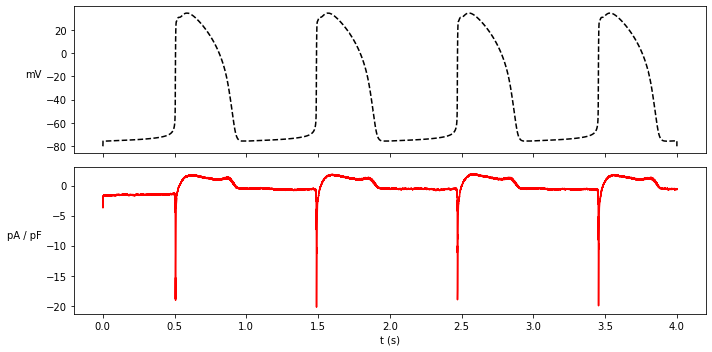

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,5))
# Draw voltage trace
ax1.plot(c5_vc.t_ms/1000, c5_vc.mV, color='black', linestyle='--')
ax1.set_ylabel('mV', color='black')
ax1.yaxis.label.set(rotation='horizontal', ha='right');

# Draw current trace
ax2.plot(c5_vc.t_ms/1000, c5_vc.i_pApF, color='red')
ax2.set_xlabel('t (s)', color='black')
ax2.set_ylabel('pA / pF')
ax2.yaxis.label.set(rotation='horizontal', ha='right');

fig.tight_layout()
plt.show()

#### Observations and notes about the data

1. The command-voltage (input) waveform was choosen before the experiment. The shape mimics 4 cardiomyocyte action potentials.

2. The temporal resolution is 0.1 ms.

3. The signal I want to isolate is nonlinear over the votlage trace and is dependent on both time and voltage.

4. There is high frequency (hf) noise component that is recorded during the experiment. The magnitude of the hf-noise is much smaller than the signal. I calibrated the equipment and try to denoise the instruments as much as possible. I also checked to ensure the hf-noise in normally distributed at several voltages prior to the experiment.

## Linear Leak Current

So far, the output signal contains a nonlinear current that is from the cell (the part to isolate) and noise from the instrument. There is an additional component in the output that arises during a voltage clamp experiment because the electrode cannot be perfectly placed on the interior of the cell membrane. This component is referred to as leak current and follows Ohm's law:
$$
    V = IR
$$
where V is the voltage, I is current and R is resistance. In voltage clamp data, I is the dependent variable and V is the independent variable. So it is more useful to rewrite the equation:
$$
    I = GV
$$
where G is the conductance and is R^-1 (in nanosiemen, nS).

A leak current by definition reverses direction at the origin (V=0, I=0). Other biological currents conduct specific ions (K+, Cl-, Na+, etc.) and do not have reversal potentials at the origin. These offsets are generated by the biological cell's electrical proteins that pump ions to different sides of the membrane creating a chemical potential.

### Fitting the leak conductance *G*

The data and the model equation for the leak component have been defined. The parameter to optimize is the leak conductance *G*. 

I will minimize the root mean squared error (RMSE) manually at first and then using library functions later.

*There is an interpretation of G that can indicate the overall quality of the data, but requires more experimental context and parameters. Since the objective is to isolate the biological current, the optimized value of G will be the value best removes the leak current.*

In [23]:
# Define the range of G that covers several orders of magnitude
g_leak = np.logspace(start=-5, stop=-1, num=50, endpoint=True)  # I used some trial and error

# Define a function to calculate RMSE
def calc_rmse(i_pApF, i_leak_pApF):
    n = float(len(i_pApF)) # number of points
    rmse = (sum((i_pApF - i_leak_pApF)**2) / n)**0.5
    return(rmse)

# Loop through and calculate the RMSE for the conductance range
rmse_leak = []
for g in g_leak:
    i_leak = (g * c5_vc.mV)
    rmse_leak.append(calc_rmse(c5_vc.i_pApF, i_leak))

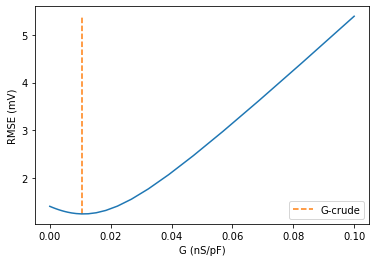

In [33]:
# Find the value of G that minimizes RMSE
g_leak_crude = g_leak[rmse_leak.index(min(rmse_leak))]

# Plot RMSE v G and G-crude
plt.plot(g_leak, rmse_leak)
plt.xlabel('G (nS/pF)')
plt.ylabel('RMSE (mV)')
plt.vlines(x = g_leak_crude, ymin = min(rmse_leak), ymax = max(rmse_leak),
           colors = 'tab:orange',
           linestyle='--',
           label = 'G-crude')
plt.legend(loc=4)
plt.show()

In [26]:
g_leak_crude = g_leak[rmse_leak.index(min(rmse_leak))]
g_leak_crude

0.010481131341546853